In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `/home/torkel.loman/mount/TeamJL/Torkel/Writings/2022, Catalyst/Catalyst-Fast-Biochemical-Modeling-with-Julia/Benchmarks/Catalyst`


In [2]:
using DiffEqBase, OrdinaryDiffEq, Catalyst, ReactionNetworkImporters,
      Sundials, Plots, DiffEqDevTools, ODEInterface, ODEInterfaceDiffEq,
      LSODA, TimerOutputs, LinearAlgebra, ModelingToolkit, BenchmarkTools

gr()
datadir  = joinpath(dirname(pathof(ReactionNetworkImporters)),"../data/bcr")
const to = TimerOutput()
tf       = 100000.0

# generate ModelingToolkit ODEs
@timeit to "Parse Network" prnbng = loadrxnetwork(BNGNetwork(), joinpath(datadir, "bcr.net"))
rn    = prnbng.rn
@timeit to "Create ODESys" osys = convert(ODESystem, rn)

tspan = (0.,tf)
@timeit to "ODEProb No Jac" oprob = ODEProblem(osys, Float64[], tspan, Float64[]);

Parsing parameters...done
Creating parameters...done
Parsing species...done
Creating species...done
Creating species and parameters for evaluating expressions...done
Parsing and adding reactions...done
Parsing groups...done


In [3]:
@timeit to "ODEProb SparseJac" sparsejacprob = ODEProblem(osys, Float64[], tspan, Float64[], jac=true, sparse=true)
show(to)

 ──────────────────────────────────────────────────────────────────────────────
                                      Time                    Allocations      
                             ───────────────────────   ────────────────────────
      Tot / % measured:            506s /  98.7%            219GiB /  99.5%    

 Section             ncalls     time    %tot     avg     alloc    %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 ODEProb SparseJac        1     408s   81.6%    408s    195GiB   89.9%   195GiB
 ODEProb No Jac           1    48.9s    9.8%   48.9s   11.4GiB    5.2%  11.4GiB
 Create ODESys            1    27.9s    5.6%   27.9s   7.51GiB    3.5%  7.51GiB
 Parse Network            1    14.9s    3.0%   14.9s   3.01GiB    1.4%  3.01GiB
 ──────────────────────────────────────────────────────────────────────────────

In [4]:
@show numspecies(rn) # Number of ODEs
@show numreactions(rn) # Apprx. number of terms in the ODE
@show length(parameters(rn)) # Number of Parameters

numspecies(rn) = 1122
numreactions(rn) = 24388
length(parameters(rn)) = 128


128

In [5]:
u  = ModelingToolkit.varmap_to_vars(nothing, species(rn); defaults=ModelingToolkit.defaults(rn))
du = copy(u)
p  = ModelingToolkit.varmap_to_vars(nothing, parameters(rn); defaults=ModelingToolkit.defaults(rn))
@timeit to "ODE rhs Eval1" oprob.f(du,u,p,0.)
@timeit to "ODE rhs Eval2" oprob.f(du,u,p,0.)
sparsejacprob.f(du,u,p,0.)

In [6]:
@btime oprob.f($du,$u,$p,0.)

  39.275 μs (3 allocations: 976 bytes)


In [7]:
Js = similar(sparsejacprob.f.jac_prototype)
@timeit to "SparseJac Eval1" sparsejacprob.f.jac(Js,u,p,0.)
@timeit to "SparseJac Eval2" sparsejacprob.f.jac(Js,u,p,0.)
show(to)

 ──────────────────────────────────────────────────────────────────────────────
                                      Time                    Allocations      
                             ───────────────────────   ────────────────────────
      Tot / % measured:           1020s /  97.7%            228GiB /  99.3%    

 Section             ncalls     time    %tot     avg     alloc    %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 SparseJac Eval1          1     465s   46.6%    465s   5.35GiB    2.4%  5.35GiB
 ODEProb SparseJac        1     408s   40.9%    408s    195GiB   86.2%   195GiB
 ODEProb No Jac           1    48.9s    4.9%   48.9s   11.4GiB    5.0%  11.4GiB
 ODE rhs Eval1            1    32.1s    3.2%   32.1s   4.01GiB    1.8%  4.01GiB
 Create ODESys            1    27.9s    2.8%   27.9s   7.51GiB    3.3%  7.51GiB
 Parse Network            1    14.9s    1.5%   14.9s   3.01GiB    1.3%  3.01GiB
 SparseJac Eval2          1    101μs   

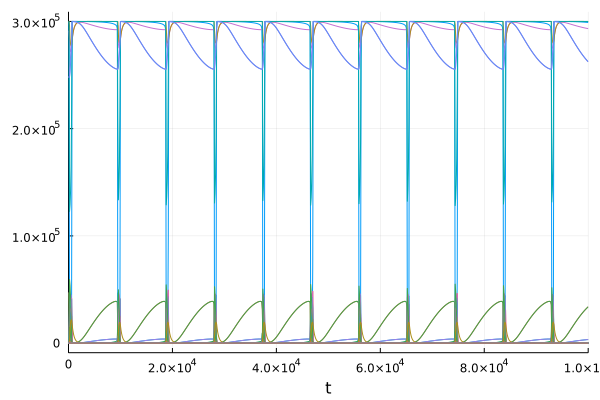

In [8]:
sol = solve(oprob, CVODE_BDF(), saveat=tf/1000., reltol=1e-5, abstol=1e-5)
plot(sol, legend=false, fmt=:png)

In [9]:
@time sol = solve(oprob, CVODE_BDF(), abstol=1/10^12, reltol=1/10^12)
test_sol  = TestSolution(sol)

793.263242 seconds (5.05 M allocations: 2.130 GiB, 0.06% gc time, 0.09% compilation time)


retcode: Success
Interpolation: 3rd order Hermite
t: nothing
u: nothing

In [10]:
abstols = 1.0 ./ 10.0 .^ (5:8)
reltols = 1.0 ./ 10.0 .^ (5:8);
setups = [
          #Dict(:alg=>Rosenbrock23(autodiff=false)),
          Dict(:alg=>TRBDF2(autodiff=false)),
          Dict(:alg=>QNDF(autodiff=false)),
          Dict(:alg=>FBDF(autodiff=false)),
          Dict(:alg=>CVODE_BDF()),
          Dict(:alg=>CVODE_BDF(linear_solver=:LapackDense)),
          #Dict(:alg=>rodas()),
          #Dict(:alg=>radau()),
          #Dict(:alg=>Rodas4(autodiff=false)),
          #Dict(:alg=>Rodas5(autodiff=false)),
          Dict(:alg=>KenCarp4(autodiff=false)),
          Dict(:alg=>KenCarp47(autodiff=false)),
          #Dict(:alg=>RadauIIA5(autodiff=false)),
          #Dict(:alg=>lsoda()),
          ];

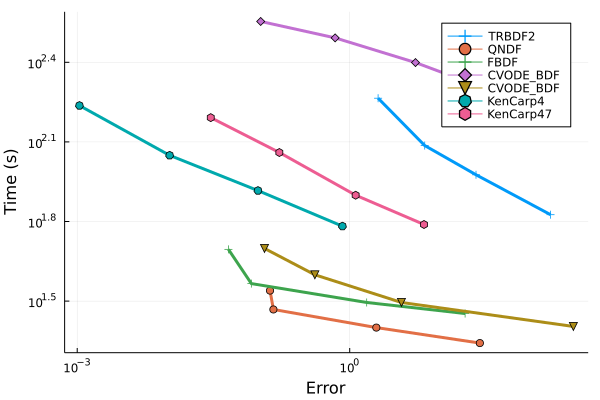

In [11]:
wp = WorkPrecisionSet(oprob,abstols,reltols,setups;error_estimate=:l2,
                      saveat=tf/10000.,appxsol=test_sol,maxiters=Int(1e5),numruns=1)
plot(wp)

In [13]:
setups = [
          Dict(:alg=>QNDF(autodiff=false)),
            Dict(:alg=>CVODE_BDF(linear_solver=:GMRES))
          ];

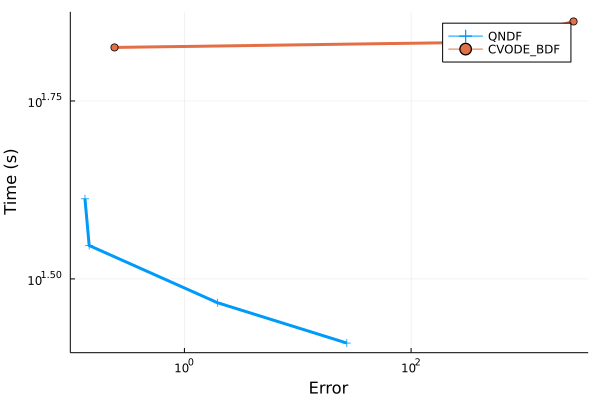

In [14]:
wp = WorkPrecisionSet(oprob,abstols,reltols,setups;error_estimate=:l2,
                      saveat=tf/10000.,appxsol=test_sol,maxiters=Int(1e5),numruns=1)
plot(wp)

In [12]:
setups = [
          #Dict(:alg=>Rosenbrock23(autodiff=false)),
          Dict(:alg=>TRBDF2(autodiff=false)),
          Dict(:alg=>QNDF(autodiff=false)),
          Dict(:alg=>FBDF(autodiff=false)),
          #Dict(:alg=>CVODE_BDF(linear_solver=:KLU)), # Fails!
          #Dict(:alg=>rodas()),
          #Dict(:alg=>radau()),
          #Dict(:alg=>Rodas4(autodiff=false)),
          #Dict(:alg=>Rodas5(autodiff=false)),
          Dict(:alg=>KenCarp4(autodiff=false)),
          Dict(:alg=>KenCarp47(autodiff=false)),
          #Dict(:alg=>RadauIIA5(autodiff=false)),
          #Dict(:alg=>lsoda()),
          ];
wp = WorkPrecisionSet(sparsejacprob,abstols,reltols,setups;error_estimate=:l2,
                      saveat=tf/10000.,appxsol=test_sol,maxiters=Int(1e5),numruns=1)
plot(wp)

LoadError: InterruptException: